# 7   Improving classification with the AdaBoost meta-algorithm

## 7.3   Creating a weak learner with a decision stump

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
from numpy import *

In [5]:
def loadSimpData():
    datMat = matrix([[1.0, 2.1], [2.0, 1.1], [1.3, 1.0], [1.0, 1.0], [2.0, 1.0]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

In [6]:
datMat, classLabels = loadSimpData()

***Listing 7.1*   Decision stump-generating functions: `stumpClassify()` & `buildStump()`**

In [8]:
import math

In [7]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = ones((shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

In [10]:
def buildStump(dataArr, classLabels, D):
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    m, n = shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m,1)))
    minError = inf
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps)+1):
            for inequal in ['lt', 'gt']:
                threshVal = rangeMin + float(j) * stepSize
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr   # Calculate weighted error
                print("split: dim %d, thresh %.2f, thresh inequal: %s, the weighted error is %.3f" % \
                     (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

In [11]:
D = mat(ones((5,1)) / 5)
buildStump(datMat, classLabels, D)

split: dim 0, thresh 0.90, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh inequal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh inequal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh inequal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh inequal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 7.4   Implementing the full AdaBoost algorithm

***Listing 7.2*   AdaBoost training with decision stumps: `adaBoostTrainDS()`**

In [14]:
def buildStump(dataArr, classLabels, D):
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    m, n = shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m,1)))
    minError = inf
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, int(numSteps)+1):
            for inequal in ['lt', 'gt']:
                threshVal = rangeMin + float(j) * stepSize
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr   # Calculate weighted error
                # print("split: dim %d, thresh %.2f, thresh inequal: %s, the weighted error is %.3f" % 
                # (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

In [15]:
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1)) / m)
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print("D: ", D.T)
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print("classEst: ", classEst.T)
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))
        D = D / D.sum()   # Calculate D for next iteration
        aggClassEst += alpha * classEst
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = aggErrors.sum() / m   # Aggregate error calculation
        print("total error: ", errorRate, "\n")
        if errorRate == 0.0:
            break
    return weakClassArr

In [16]:
classifierArray = adaBoostTrainDS(datMat, classLabels, 9)

D:  [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

D:  [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

D:  [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



In [17]:
classifierArray

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

## 7.5   Test: classifying with AdaBoost

***Listing 7.3*   AdaBoost classification function: `adaClassify()`**

In [22]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = mat(datToClass)
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], \
                                 classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return sign(aggClassEst)

In [23]:
datArr, labelArr = loadSimpData()
classifierArr = adaBoostTrainDS(datArr, labelArr, 30)

D:  [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

D:  [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

D:  [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



In [24]:
adaClassify([[5, 5], [0, 0]], classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

## 7.6   Example: AdaBoost on a difficult dataset

***Listing 7.4*   Adaptive load data function: `loadDataSet()`**

In [25]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [26]:
datArr, labelArr = loadDataSet('/Users/duoduo/Desktop/Data/Machine Learning/Machine Learning in Action/MLA_SourceCode/Ch07/horseColicTraining2.txt')

In [28]:
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1)) / m)
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        # print("D: ", D.T)
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        # print("classEst: ", classEst.T)
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))
        D = D / D.sum()   # Calculate D for next iteration
        aggClassEst += alpha * classEst
        # print("aggClassEst: ", aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = aggErrors.sum() / m   # Aggregate error calculation
        print("total error: ", errorRate, "\n")
        if errorRate == 0.0:
            break
    return weakClassArr

In [29]:
classifierArray = adaBoostTrainDS(datArr, labelArr, 10)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 



In [30]:
testArr, testLabelArr = loadDataSet('/Users/duoduo/Desktop/Data/Machine Learning/Machine Learning in Action/MLA_SourceCode/Ch07/horseColicTest2.txt')

In [31]:
prediction10 = adaClassify(testArr, classifierArray)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [32]:
errArr = mat(ones((67,1)))
errArr[prediction10 != mat(testLabelArr).T].sum()

16.0

In [34]:
errorRate10 = errArr[prediction10 != mat(testLabelArr).T].sum() / 67
errorRate10

0.23880597014925373

## 7.7   Classification imbalance

### 7.7.1   Alternative performance metrics: precision, recall, and ROC

***Listing 7.5*   ROC plotting and AUC calculating function: `plotROC()`**

In [38]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(array(classLabels) == 1.0)
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    sortedIndices = predStrengths.argsort()   # Get sorted index
    fig = plt.figure()
    fig.clf
    ax = plt.subplot(111)
    for index in sortedIndices.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c = 'b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0,1], [0,1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ", ySum * xStep)

In [39]:
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1)) / m)
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        # print("D: ", D.T)
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        # print("classEst: ", classEst.T)
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))
        D = D / D.sum()   # Calculate D for next iteration
        aggClassEst += alpha * classEst
        # print("aggClassEst: ", aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m,1)))
        errorRate = aggErrors.sum() / m   # Aggregate error calculation
        # print("total error: ", errorRate, "\n")
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

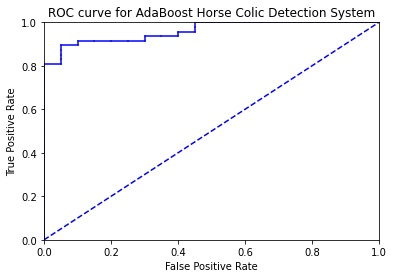

the Area Under the Curve is:  0.9595744680851065


In [41]:
datArr, labelArr = loadDataSet('/Users/duoduo/Desktop/Data/Machine Learning/Machine Learning in Action/MLA_SourceCode/Ch07/horseColicTest2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)

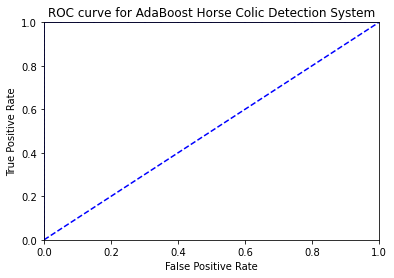

the Area Under the Curve is:  1.0


In [42]:
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 40)
plotROC(aggClassEst.T, labelArr)